<a href="https://colab.research.google.com/github/marco-siino/GM_SOURCE_CODE/blob/main/AMD_DS/Prompting_Mistral_Large_Heterogeneus_Device_Mapping_DS_Devmap_AMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Additional experiments for EAAI Submission. Prompt engineering for device mapping (GPU vs CPU) using Mistral Large.

Streaming output truncated to the last 5000 lines.

     j = get_global_id(0) + g;
     k = get_local_id(0);

     if (j < h) {
       __global double(*m)[12 + 2] = (__global double(*)[12 + 2])a;
       __global double(*n)[12 + 2] = (__global double(*)[12 + 2])b;

       for (i = e; i < f; i++) {
         l = l + (m[j][i] + m[j][i + 1] + m[j + 1][i] + m[j + 1][i + 1] + n[j][i] + n[j][i + 1] + n[j + 1][i] + n[j + 1][i + 1]);
       }
     }
     d[k] = l;

     barrier(1);

     if (k == 0) {
       for (i = 1; i < get_local_size(0); i++) {
         l += d[i];
       }

       c[get_group_id(0)] = l;
     }
   }
   ```
   **Label: GPU**
   - **Reason:** This kernel employs a parallel reduction pattern, which is well-suited for GPU execution. The use of `__local` memory and the `barrier` function suggests that it is designed to take advantage of the parallel processing capabilities of a GPU.

2. **Kernel 2:**
   ```opencl
   __kernel void A(__global double* a, __global double* b, __globa

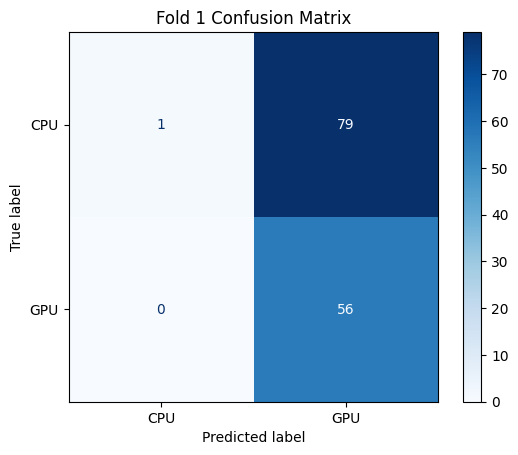

Streaming output truncated to the last 5000 lines.
      s[2] += u[3] * t[3][2];
      s[3] += u[3] * t[3][3];
      s[4] += u[3] * t[3][4];
      s[5] += u[3] * t[3][5];
      s[6] += u[3] * t[3][6];
      s[7] += u[3] * t[3][7];
      s[8] += u[3] * t[3][8];
      s[9] += u[3] * t[3][9];
      s[10] += u[3] * t[3][10];
      s[11] += u[3] * t[3][11];
      s[12] += u[3] * t[3][12];
      s[13] += u[3] * t[3][13];
      s[14] += u[3] * t[3][14];
      s[15] += u[3] * t[3][15];
    } while (0);
    u[3] = a[3 * b];

    a += 4 * b;
    do {
      s[0] += u[0] * t[4][0];
      s[1] += u[0] * t[4][1];
      s[2] += u[0] * t[4][2];
      s[3] += u[0] * t[4][3];
      s[4] += u[0] * t[4][4];
      s[5] += u[0] * t[4][5];
      s[6] += u[0] * t[4][6];
      s[7] += u[0] * t[4][7];
      s[8] += u[0] * t[4][8];
      s[9] += u[0] * t[4][9];
      s[10] += u[0] * t[4][10];
      s[11] += u[0] * t[4][11];
      s[12] += u[0] * t[4][12];
      s[13] += u[0] * t[4][13];
      s[14] += u[0] * t[4

In [ ]:
!pip install mistralai
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from mistralai import Mistral
from tqdm import tqdm

# Inizializza Mistral API
client = Mistral(api_key='7yOu0lH5XcZC1U2ZUI2uv0ghBDduhHp5')
model = "mistral-large-latest"

# Carica dataset
df = pd.read_csv("/content/dataset-devmap-amd.csv")
df = df[["src", "oracle"]]  # src = codice, oracle = label ("CPU"/"GPU")

# Mapping etichette
text_to_label = {"CPU": 0, "GPU": 1}
label_to_text = {0: "CPU", 1: "GPU"}

# Seed per riproducibilità
random.seed(42)
np.random.seed(42)

# Setup K-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(df["src"], df["oracle"])):
    print(f"\nFold {fold + 1}")
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    # Prompt iniziale con istruzioni
    few_shot_prompt = (
        "Classify whether the following OpenCL kernel should run on CPU or GPU based on its characteristics.\n"
        "The label should be either 'CPU' or 'GPU'.\n\n"
    )

    # Seleziona 5 esempi few-shot
    few_shot_samples = train_df.sample(n=5, random_state=fold)
    for _, row in few_shot_samples.iterrows():
        few_shot_prompt += f"Code:\n{row['src']}\nLabel: {row['oracle']}\n\n"

    preds = []
    golds = []
    texts = []

    for i, (code_snippet, true_label) in enumerate(zip(val_df["src"], val_df["oracle"])):
        print("\n######### Avvio Predizione Numero "+str(i)+" del validation set relativo al FOLD " +str(fold) + " ###########")
        golds.append(text_to_label[true_label])
        prompt = few_shot_prompt + f"Code:\n{code_snippet}\nLabel:"
        message = [{"role": "user", "content": prompt}]

        try:
            chat_response = client.chat.complete(
                model=model,
                messages=message
            )
            completion = chat_response.choices[0].message.content.strip()

            # Normalizzazione
            if "gpu" in completion.lower():
                pred_label = 1
            elif "cpu" in completion.lower():
                pred_label = 0
            else:
                pred_label = random.choice([0, 1])  # fallback

        except Exception as e:
            print(f"Errore nella predizione: {e}")
            pred_label = random.choice([0, 1])

        preds.append(pred_label)
        texts.append(completion)
        print(f"[{i}] Pred: {label_to_text[pred_label]} | True: {true_label} | GPT output: {completion}")
        print("\n######### PREDIZIONE TERMINATA. Numero "+str(i)+" del validation set relativo al FOLD " +str(fold) + " ###########")

    # Accuracy e confusion matrix
    acc = accuracy_score(golds, preds)
    print(f"Fold {fold + 1} accuracy: {acc:.4f}")
    accuracies.append(acc)

    cm = confusion_matrix(golds, preds, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["CPU", "GPU"])
    disp.plot(cmap="Blues")
    plt.title(f"Fold {fold + 1} Confusion Matrix")
    plt.show()

# Media finale
print(f"\nAverage accuracy over all folds: {np.mean(accuracies):.4f}")
